## Objetivo
Se analizan tres posibles análisis
- Vizualización de datos (histograma y mapa)
- Análisis de segregación espacial
- Análisis de redes

In [172]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt ## libreria para la visualización de data

import redapy

### Vizualización de datos (histograma y mapa)
Para el siguiente ejemplo del uso de Redapy, vamos a explorar las características de la población que vive en viviendas alquiladas en Lima metropolitana en el año 2017

#### Distritos
Iniciamos identificando a las personas que vivien en viviendas alquiladas, para ello usaremos la variables del cuestionario de vivienda denominadad "vivienda.C2P13". Para optener el resultado esperado, además de la variables tenemos que específicar el nivel de salida de la variables y el ubigeo. En este caso, usaremos el nivel distrital (area_break=ditrito) para el ubigeo provincial de Lima Metropolina (selection="1501").

_Tengamos en cuenta que la función para hacer el wrapper al procesador estadistico y la función para la limpieza de las tablas están separadas_

In [76]:
query=redapy.query_final(tipo='Frequency',var1="vivienda.C2P13",area_break="distrito",selection="1501")
df=redapy.make_query_2017(query)
df.iloc[17:31]

Scrapeo iniciado
Se cargó página REDATAM con éxito
La tabla cargó completamente
Tabla scrapeada con éxito en: 0:00:08.654985


,0,1,2,3,4,5
17,NaN,AREA # 150102,"Lima, Lima, distrito: Ancón",NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,V: Tenencia de la vivienda - La vivienda que o...,Casos,%,Acumulado %,NaN
20,NaN,Alquilada,1 134,"6,78%","6,78%",NaN
21,NaN,Propia sin título de propiedad,9 539,"57,03%","63,81%",NaN
22,NaN,Propia con título de propiedad,5 111,"30,56%","94,36%",NaN
23,NaN,Cedida,926,"5,54%","99,90%",NaN
24,NaN,Otra forma,17,"0,10%","100,00%",NaN
25,NaN,Total,16 727,"100,00%","100,00%",NaN
26,NaN,NaN,NaN,NaN,NaN,NaN


En la tabla anterior observamos que se han descargado las tablas tal como ocurriria desde el portal web de Redatam: una tabla por **UBIGEO**. Ahora lo que se requiere es tranformar estas tablas individuales en una matriz que permita trabajar los datos en foma de _dataframe_ y trasladarlos a otros análisis como el que se puede hace con GIS. Para ello, usaremos la función denominada **frequency** y el parametro pivot=True, que permite pivotear el resultado para una visualización más sencilla.

In [78]:
df1=redapy.frequency(df, pivot=True)
df1.head(5) ## Solo visualizamos las primeras 5 filas

resp,Alquilada,Cedida,Otra forma,Propia con título de propiedad,Propia sin título de propiedad
ubigeo,,,,,
150101,26985,5326,200,31809,10045
150102,1134,926,17,5111,9539
150103,38579,9859,191,56636,46421
150104,3802,549,39,5529,1034
150105,9988,1396,63,9972,2980


Ahora tenemos todas las varibles en una matriz de 2x2, donde el index es igual al ubigeo y las columnas son las categorias de la variable de tenencia de la propiedad. Este resultado ya puede ser usado para graficar las frecuencias de datos o pasarlo a un programa de GIS. Sin embargo, antes calcularemos el total y los porcentajes relativos para cada ubigeo.

In [79]:
## creamos una variable con la suma total de casos por ubigeo
df1['viviendas_total']=df1.sum(axis=1) 
## creamos una variable con el porcentaje de la variable vivienda alquilada con respecto al total de viviendas
df1['alquiler_p']=((df1.Alquilada/df1.viviendas_total)*100).round(1)
## Ahora mostramos las 5 primeras filas con la condición de que estén ordenadas de mayor a menor
df1.sort_values("alquiler_p",ascending=False).head(5)

resp,Alquilada,Cedida,Otra forma,Propia con título de propiedad,Propia sin título de propiedad,viviendas_total,alquiler_p
ubigeo,,,,,,,
150115,22935,3043,113,17967,4730,48788,47.0
150137,22872,4734,55,14796,9336,51793,44.2
150105,9988,1396,63,9972,2980,24399,40.9
150134,5471,805,24,6083,1219,13602,40.2
150141,10159,1303,58,13129,3177,27826,36.5


Vemos que en los ditritos de la Victoria (150115), Santa Anita (150137), Breña, San Luis y Surquillo, se encuentran el mayor número de viviendas alquiladas en el año 2017, respectivamente.
No obstante, que la vivienda se encuentre alquilada no quiere decir que la mayoría de hogares o personas del distrito habiten en dichas viviendas. Por esta razón calculamos la misma información pero a nivel de persona censada. Para ello usaremos nuevamente el módulo de redapy, pero esta vez pasaremos dos variables. Esto se logra utilizando la opción "Crosstab" en el parametro _tipo_.

In [87]:
query=redapy.query_final(tipo='Crosstab',var1="vivienda.C2P13", var2="poblacion.C5P2",area_break="distrito",selection="1501")
df=redapy.make_query_2017(query)
df2=redapy.cross_table(df)

## Nos quedamos con la variable total
df2=df2.reset_index().query('columna=="Total"').pivot(index="ubigeo",columns="fila",values="freq")
df2['pob_total']=df2.sum(axis=1) 
## creamos una variable con el porcentaje de la variable vivienda alquilada con respecto al total de viviendas
df2['alquiler_pob_p']=((df2.Alquilada/df2.pob_total)*100).round(1)
## Ahora mostramos las 5 primeras filas con la condición de que estén ordenadas de mayor a menor
df2.sort_values("alquiler_pob_p",ascending=False).head(9)

Scrapeo iniciado
Se cargó página REDATAM con éxito
La tabla cargó completamente
Tabla scrapeada con éxito en: 0:00:06.895664


fila,Alquilada,Cedida,Otra forma,Propia con título de propiedad,Propia sin título de propiedad,pob_total,alquiler_pob_p
ubigeo,,,,,,,
150115,73605,10712,400,67698,17302,169717,43.4
150105,31795,4968,205,35794,10286,83048,38.3
150137,69309,18334,188,65667,40722,194220,35.7
150116,18446,2768,61,28427,4417,54119,34.1
150134,17293,3084,81,25532,5027,51017,33.9
150141,29081,4415,185,43873,11397,88951,32.7
150101,84801,19113,672,120840,36438,261864,32.4
150104,10620,1769,138,17827,3464,33818,31.4
150122,29951,2461,166,58847,5897,97322,30.8


En relación a la población en vivienda alquiladas, vemos que el distrito de Breña a pesar de ser el tercero con más viviendas alquiladas, es el segundo distrito con más población en viviendas alquiladas. Situación similar ocurre con el distrito de Lince (150116) que a pesar de tener solo vivienda en alquiler, es el quito con más población habitandolas. Esta última idea, no lleva a la siguiente pregunta, ¿cuál es el ratio entre población y viviendas alquiladas? Para resolver esta pregunta, procederemos a unir ambos _Dataframes_ y calcular nuestro indicador.

Como veremos a continuación, este ejercicio resulta mucho más sencillo, gracias a que la función de limpieza de Redapy toma al ubigeo como variable clave para indexar la información

In [84]:
df3=(df1[["Alquilada","viviendas_total","alquiler_p"]].
     join(df2.rename({"Alquilada":"Alquilada_pob"},axis=1)[["Alquilada_pob","pob_total","alquiler_pob_p"]]))

df3["ratio"]=(df3.Alquilada_pob/df3.Alquilada).round(2)
df3.sort_values("ratio",ascending=False).head()

,Alquilada,viviendas_total,alquiler_p,Alquilada_pob,pob_total,alquiler_pob_p,ratio
ubigeo,,,,,,,
150142,11964,83775,14.3,47610,389331,12.2,3.98
150106,10497,79541,13.2,39551,330190,12.0,3.77
150125,12092,79210,15.3,45099,325718,13.8,3.73
150143,8881,93821,9.5,33061,393360,8.4,3.72
150133,13078,78130,16.7,48525,350551,13.8,3.71


Luego de cruzar ambos _dataframes_, observamos que el ratio más alto de personas por vivienda alquilada se encuentra en el distrito de Villa el Salvador, ello a pesar de que el porcentaje de población en vivienda alquiladas es de solo 12%. Por su parte, el distrito de Miraflores tiene el ratio más bajo de personas por vivienda alquilada, esto a pesar de ser el 9no distrito con más población en viviendas alquiladas con 31% de vecinos en viviendas alquiladas.

In [85]:
df3.sort_values("ratio",ascending=False).tail()

,Alquilada,viviendas_total,alquiler_p,Alquilada_pob,pob_total,alquiler_pob_p,ratio
ubigeo,,,,,,,
150141,10159,27826,36.5,29081,88951,32.7,2.86
150104,3802,10953,34.7,10620,33818,31.4,2.79
150131,5084,20652,24.6,13717,59872,22.9,2.70
150138,51,282,18.1,137,985,13.9,2.69
150122,12537,36953,33.9,29951,97322,30.8,2.39


#### Visualización en forma de mapa
Ahora que tenemos nuestros dos indicadores podemos realizar una visualización de ambos en forma de mapa por límites distritales. Para ello usaremos la libreria **_geopandas_**, la cual permite trabajar con datos vectoriales. Además, usaremos los shps de distritos 2017 descargados del siguiente enlace:

_Este mismo ejercicio de visualización se puede realizar con otros programas de GIS como, por ejemplo, QGIS_

Text(0.5, 1.0, 'Ratio entre el total de personas en viviendas\n alquiladas y el total de viviendas alquiladas')

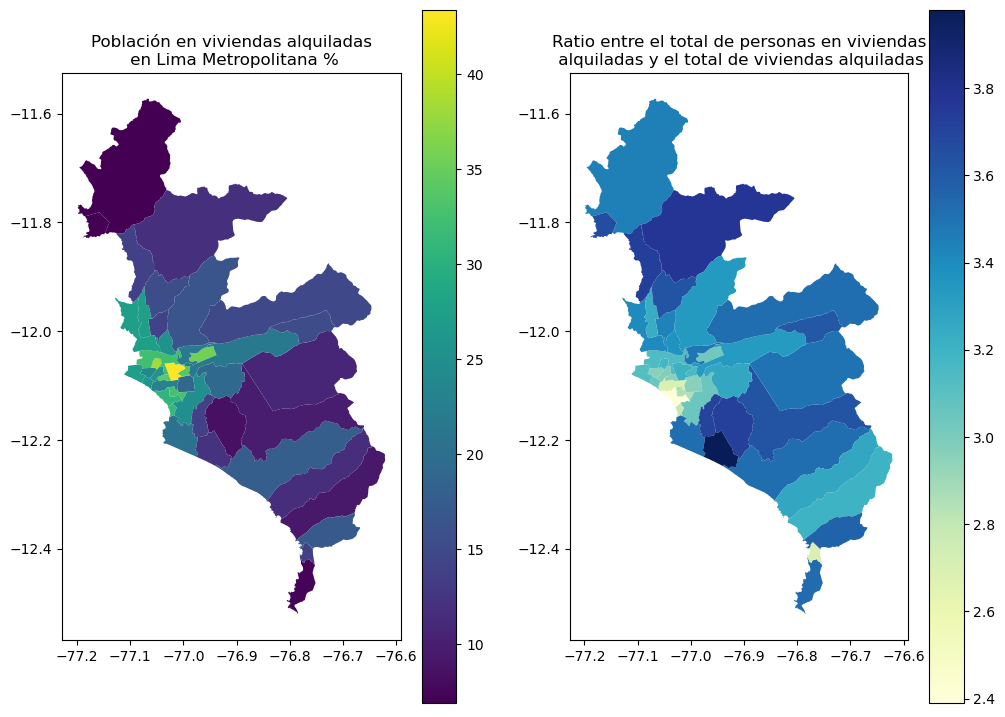

In [171]:
## Hacemos el merge entre la BD espacial y nuestro dataframe con los indicadores que queremos graficar
dis17=gpd.read_file('Bases originales\\Límites nacionales\\DISTRITOS.zip')
dis17=dis17.set_index('IDDIST').merge(df3, right_index=True, left_index=True, how='inner', validate='1:1')

## Usaremos la libreía Matplotlib para graficar el resultado
fig,ax=plt.subplots(1,2, figsize=(12,9))

dis17.plot("alquiler_pob_p",ax=ax[0], legend=True)
dis17.plot("ratio",ax=ax[1], legend=True, cmap="YlGnBu")

ax[0].set_title("Población en viviendas alquiladas\n en Lima Metropolitana %") 
ax[1].set_title("Ratio entre el total de personas en viviendas\n alquiladas y el total de viviendas alquiladas") 


### Filtros para consultas en REDATAM

Ahora que sabemos el total de población en viviendas alquiladas, podríamos explorar algunas características de su población, como por ejemplo el el ciclo del hogar o si el jefe del hogar vivia en Lima Metropolitana en los últimos 5 años. Para ello necesitaremos hacer otra consulta a redatam especificando el tipo de consulta y las categorias de las variables filtro para que retorne información solo del jefe del hogar que vivi en viviendas alquiladas.

Para ello volveremos usar la tabla de frecuencia, pero a al vez usaremos el parámetro _for_query_ con el cual pasaremos un diccionario con los valores para la consulta

In [136]:
query=redapy.query_final(tipo='Frequency',var1="poblacion.C5P2",area_break="distrito",selection="1501",
                        for_query={'variables':["vivienda.C2P13","poblacion.C5P1"],
                                   'category':["1","1"],
                                   'logical_exp':["equal"],
                                   'operator':['and']})

df=redapy.make_query_2017(query, mensajes=False)
df4=redapy.frequency(df, pivot=True)
print(df4.head())

df4['total_jefe_h']=df4.sum(axis=1)
for p in df4.columns:
    df4[p]=((df4[p]/df4['total_jefe_h'])*100).round(1)
df4.sort_values("Mujer", ascending=False).head()

resp,Hombre,Mujer,total_jefe_h
ubigeo,,,
150138,50.0,50.0,100.0
150113,55.4,44.6,100.0
150121,57.6,42.4,100.0
150104,57.8,42.2,100.0
150116,58.1,41.9,100.0


Una de las ventajas de geopandas, es que cuenta con método para generar mapas interactivos. Este método se llama "explore"